In [1]:
import os
from IPython.display import clear_output
%pip install wandb==0.16.0 -q
%pip install --upgrade datasets -q
%pip install efficientnet
%pip install aiffel7
%pip install git+https://github.com/tensorflow/examples.git
clear_output(wait=False)

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import os
import albumentations as A
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow import keras
import math
import random
import pickle
from skimage.io import imread, imshow,show
from skimage.transform import resize
from glob import glob
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

import keras.backend as K

In [3]:
from datasets import load_dataset
dataset = load_dataset("nateraw/pascal-voc-2012")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256

In [5]:
print("데이터셋 정보:")
print(dataset)

데이터셋 정보:
DatasetDict({
    train: Dataset({
        features: ['image', 'mask'],
        num_rows: 1464
    })
    val: Dataset({
        features: ['image', 'mask'],
        num_rows: 1449
    })
})


In [6]:
test_dataset=dataset["train"]

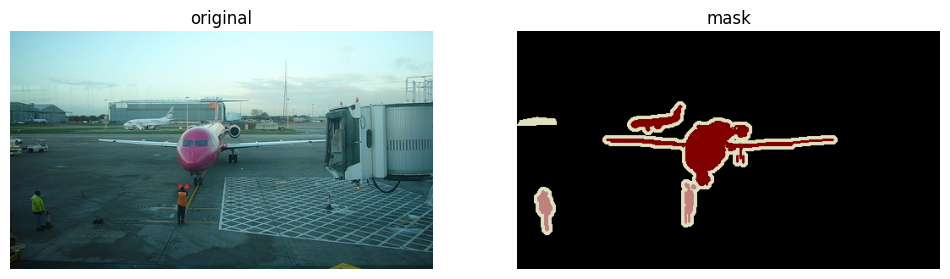

In [7]:
# 첫 번째 데이터 샘플을 로드
first_sample = test_dataset[0]
image = first_sample['image']
mask = first_sample['mask']

# 이미지와 마스크 표시
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 원본 이미지
ax[0].imshow(image)
ax[0].set_title('original')
ax[0].axis('off')

# 마스크 이미지
ax[1].imshow(mask)
ax[1].set_title('mask')
ax[1].axis('off')

plt.show()

In [8]:
from PIL import Image
import numpy as np

# 이미지와 마스크를 NumPy 배열로 변환
input_images = np.array(test_dataset[0]['image'])
input_labels = np.array(test_dataset[0]['mask'])

# 변환된 배열의 형태 확인
print("Images shape:", input_images.shape)
print("Labels shape:", input_labels.shape)

Images shape: (281, 500, 3)
Labels shape: (281, 500, 3)


In [9]:
import numpy as np
from PIL import Image

def extract_class_color_mapping(masks):
    """
    마스크 이미지들에서 클래스별 색상 매핑을 추출하는 함수
    :param masks: 마스크 이미지의 리스트
    :return: 클래스와 색상의 매핑 딕셔너리
    """
    color_mapping = {}
    class_id = 0

    for mask in masks:
        # 마스크 이미지를 NumPy 배열로 변환
        mask_np = np.array(mask)
        # 고유한 색상 찾기
        unique_colors = np.unique(mask_np.reshape(-1, mask_np.shape[2]), axis=0)

        for color in unique_colors:
            # 색상을 튜플로 변환
            color_tuple = tuple(color)
            # 새로운 색상이면 클래스 ID 할당
            if color_tuple not in color_mapping:
                color_mapping[color_tuple] = class_id
                class_id += 1

    return color_mapping




def map_integer_mask_to_color(integer_mask, reverse_mapping):
    color_mask = np.zeros((integer_mask.shape[0], integer_mask.shape[1], 3), dtype=np.uint8)
    for row in range(integer_mask.shape[0]):
        for col in range(integer_mask.shape[1]):
            class_idx = integer_mask[row, col]
            color = reverse_mapping[class_idx]
            # 컬러 값을 [0, 255] 범위로 스케일링
            scaled_color = np.clip(color, 0, 255)
            color_mask[row, col] = scaled_color

    return color_mask
def create_inverse_mapping(class_color_mapping):
    """
    클래스 ID에서 색상으로의 역 매핑을 생성하는 함수
    :param class_color_mapping: 클래스와 색상의 매핑 딕셔너리
    :return: 역 매핑 딕셔너리
    """
    inverse_mapping = {class_id: color for color, class_id in class_color_mapping.items()}
    return inverse_mapping

In [10]:

# 데이터셋에서 마스크 목록 추출
masks = [sample['mask'] for sample in test_dataset]
pickle_file = 'class_color_mapping.pkl'
if not os.path.exists(pickle_file):
    # masks 변수는 이미 정의되어 있어야 합니다.
    class_color_mapping = extract_class_color_mapping(masks)

    # 추출한 매핑을 pickle 파일로 저장
    with open(pickle_file, 'wb') as file:
        pickle.dump(class_color_mapping, file)
else:
    # 파일이 이미 존재하는 경우, pickle 파일에서 데이터 불러오기
    with open(pickle_file, 'rb') as file:
        class_color_mapping = pickle.load(file)

In [11]:
pickle_file_inverse_mapping = 'inverse_mapping.pkl'
if not os.path.exists(pickle_file_inverse_mapping):

    inverse_mapping = create_inverse_mapping(class_color_mapping)
    # 추출한 매핑을 pickle 파일로 저장
    with open(pickle_file_inverse_mapping, 'wb') as file:
        pickle.dump(inverse_mapping, file)
else:
    # 파일이 이미 존재하는 경우, pickle 파일에서 데이터 불러오기
    with open(pickle_file_inverse_mapping, 'rb') as file:
        inverse_mapping = pickle.load(file)

In [12]:
print(class_color_mapping)
print(inverse_mapping)

{(0, 0, 0): 0, (128, 0, 0): 1, (192, 128, 128): 2, (224, 224, 192): 3, (0, 64, 128): 4, (64, 0, 128): 5, (192, 0, 0): 6, (128, 128, 0): 7, (128, 0, 128): 8, (0, 0, 128): 9, (192, 128, 0): 10, (128, 192, 0): 11, (64, 128, 128): 12, (192, 0, 128): 13, (64, 128, 0): 14, (0, 128, 0): 15, (128, 128, 128): 16, (64, 0, 0): 17, (0, 192, 0): 18, (0, 128, 128): 19, (0, 64, 0): 20, (128, 64, 0): 21}
{0: (0, 0, 0), 1: (128, 0, 0), 2: (192, 128, 128), 3: (224, 224, 192), 4: (0, 64, 128), 5: (64, 0, 128), 6: (192, 0, 0), 7: (128, 128, 0), 8: (128, 0, 128), 9: (0, 0, 128), 10: (192, 128, 0), 11: (128, 192, 0), 12: (64, 128, 128), 13: (192, 0, 128), 14: (64, 128, 0), 15: (0, 128, 0), 16: (128, 128, 128), 17: (64, 0, 0), 18: (0, 192, 0), 19: (0, 128, 128), 20: (0, 64, 0), 21: (128, 64, 0)}


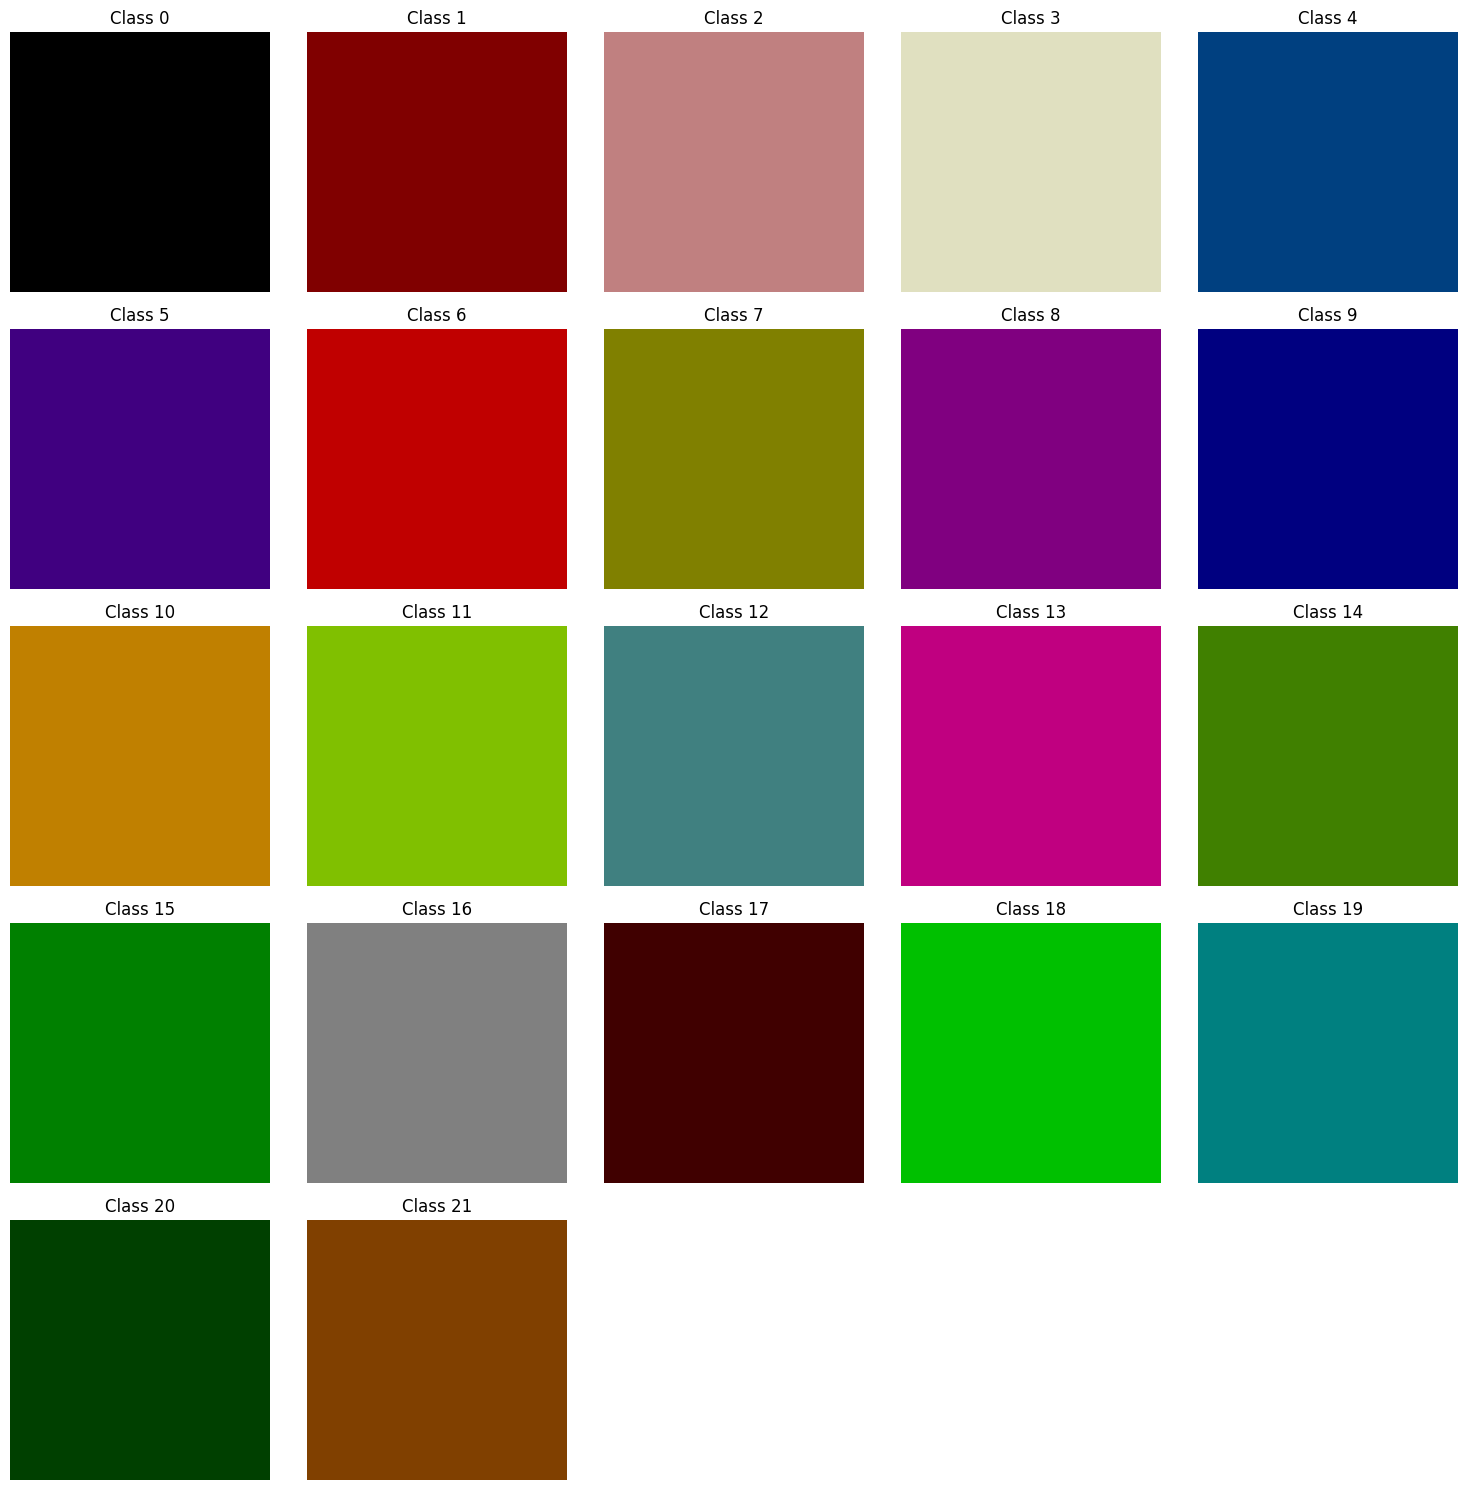

In [13]:
# 5행 5열의 서브플롯 생성
plt.figure(figsize=(15, 15))
for class_id, color in inverse_mapping.items():
    ax = plt.subplot(5, 5, class_id + 1)
    ax.set_title(f"Class {class_id}")
    ax.imshow(np.full((10, 10, 3), color, dtype=np.uint8))  # 색상으로 채운 작은 이미지 생성
    ax.axis('off')

# 나머지 빈 서브플롯 숨기기
for i in range(len(inverse_mapping) + 1, 26):
    ax = plt.subplot(5, 5, i)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [14]:
from PIL import ImageOps
def map_colors_to_labels(seg, color_mapping):
    # 세그멘테이션 마스크의 높이와 너비를 얻습니다.
    height, width = seg.shape[:2]
    non_zero_indices = np.nonzero(seg)

    # 행과 열 인덱스를 튜플로 묶어 딕셔너리 생성
    index_dict = {}

    for i in range(len(non_zero_indices[0])):
        key = (non_zero_indices[0][i], non_zero_indices[1][i])
        index_dict[key] = 1
    # 새로운 레이블 배열을 생성합니다.
    label_seg = np.zeros((height, width), dtype=np.int32)
    for i in index_dict.keys():

        y = i[0]
        x = i[1]

        # 현재 픽셀의 RGB 값을 가져옵니다.
        pixel = tuple(seg[y, x])

        # RGB 값에 해당하는 레이블을 찾아 할당합니다.
        label_seg[y, x] = color_mapping.get(pixel, 0)  # 기본값으로 0을 사용

    return label_seg
def data_concat(dataset):

    img_arr = []
    seg_arr = []

    img_arr_temp = dataset['train']['image'] + dataset['val']['image']

    seg_arr_temp = dataset['train']['mask'] + dataset['val']['mask']

    for img, seg in zip(img_arr_temp, seg_arr_temp):
        img = np.array(img.resize((IMG_WIDTH, IMG_HEIGHT),Image.NEAREST))
        seg = np.array(seg.resize((IMG_WIDTH, IMG_HEIGHT),Image.NEAREST))
        label_seg = map_colors_to_labels(seg, class_color_mapping)
        img_arr.append(img)
        seg_arr.append(label_seg)

    return np.array(img_arr), np.array(seg_arr)

In [15]:
full_dataset = tf.data.Dataset.from_tensor_slices(data_concat(dataset))
print(full_dataset)

<_TensorSliceDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(256, 256), dtype=tf.int32, name=None))>


In [16]:
DATASET_SIZE = 2913
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.2 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

full_dataset = full_dataset.shuffle(buffer_size = DATASET_SIZE)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [17]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

def load_image_train(input_image, input_mask):
    input_mask = input_mask[ ..., np.newaxis]


    # random flip the image and mask
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_mask = input_mask[:, :, 0]
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask
def load_image_test(input_image, input_mask):
    input_mask = input_mask[np.newaxis, ...]


    input_mask = input_mask[0]
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [18]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = train_size // BATCH_SIZE
train = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val = train_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)
val_dataset = val.batch(BATCH_SIZE)

In [19]:
# 저장된 모델의 경로
model_path_unet_e = '/content/drive/MyDrive/DL THON/UNET_effecientTP.keras'

# 모델 로드
model_ue = tf.keras.models.load_model(model_path_unet_e)

In [20]:
# 저장된 모델의 경로
model_path_unet_m = '/content/drive/MyDrive/DL THON/UNET_mobile.keras'

# 모델 로드
model_um = tf.keras.models.load_model(model_path_unet_m)

In [21]:
@tf.keras.utils.register_keras_serializable()
def iou_score(target, prediction):
    target = tf.squeeze(target,-1)
    target = tf.convert_to_tensor(target, dtype=tf.float32)
    prediction = tf.convert_to_tensor(prediction, dtype=tf.float32)

    intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.cast(target, tf.bool), tf.cast(prediction, tf.bool)), tf.float32))
    union = tf.reduce_sum(tf.cast(tf.logical_or(tf.cast(target, tf.bool), tf.cast(prediction, tf.bool)), tf.float32))

    iou_score = tf.math.divide_no_nan(intersection, union)

    return iou_score

In [22]:
# 저장된 모델의 경로
model_path_deeplab = '/content/drive/MyDrive/DL THON/deeplabv3.keras'

# 모델 로드
model_deeplab = tf.keras.models.load_model(model_path_deeplab, custom_objects={'iou_score': iou_score})

In [40]:
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU

# 가정: y_true와 y_pred는 모델에 의해 예측된 세그멘테이션 마스크와 실제 마스크입니다.
# 이들은 모두 동일한 형태(shape)를 가지며, 각 픽셀의 클래스 레이블을 포함합니다.
# num_classes는 데이터셋에 있는 클래스의 총 수입니다.

def calculate_miou(y_true, y_pred, num_classes):

    # MeanIoU 객체를 생성합니다.
    miou = MeanIoU(num_classes=num_classes)
    # 업데이트 메소드를 호출하여 실제 값과 예측 값을 전달합니다.
    miou.update_state(y_true, y_pred)
    # 결과를 계산합니다.
    result = miou.result().numpy()  # TensorFlow 2.x에서는 .numpy()를 호출하여 값을 얻습니다.
    return result

In [63]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(np.array(display_list[i]))
        plt.axis('off')
    plt.show()

In [74]:
import numpy as np
import tensorflow as tf

num_classes = 22

def calculate_miou_custom(model_list, num_classes):
    # 테스트 데이터셋에서 모델 예측 수행
    for image, mask in test_dataset.take(10):

        for model_name, model in model_list.items():
          y_pred = model.predict(image)
          y_true = mask

          y_pred = tf.argmax(y_pred, axis=-1)
          y_pred = np.squeeze(y_pred[..., tf.newaxis],-1)

          display([image[0], y_true[0], y_pred[0]])

          # MeanIoU 인스턴스 생성
          iou_metric = MeanIoU(num_classes=num_classes)

          # 업데이트
          iou_metric.update_state(y_true, y_pred)

          # confusion matrix 얻기
          conf_mat = iou_metric.get_weights()[0]

          # 각 클래스별 IoU 계산
          ious = []
          for i in range(num_classes):
              # 대각선 값은 교차, 행의 합과 열의 합은 합집합을 나타냄
              true_positives = conf_mat[i, i]
              false_negatives = np.sum(conf_mat[i, :]) - true_positives
              false_positives = np.sum(conf_mat[:, i]) - true_positives
              iou = true_positives / (true_positives + false_positives + false_negatives)
              ious.append(iou)

          # 출력
          print(f"{model_name} Class-wise IoU:", ious)

          # 0.5보다 큰 값들을 필터링

          filtered_values = np.array([x for x in ious if x > 0.5])
          filtered_data = filtered_values[~np.isnan(filtered_values)]

          # 필터링된 값들의 평균 계산
          ious_up = filtered_data.mean()
          print(f"{model_name} Mean IoU score > 0.5: ", ious_up)

          # 상위 3값의 평균 계산
          ious_top3 = np.mean(np.sort(filtered_data)[-3:])
          print(f"{model_name} Mean IoU score top 3: ", ious_top3)

          miou_score = calculate_miou(y_true.numpy(), y_pred, num_classes)
          print(f"{model_name} Mean IoU score: {miou_score}")
        print("-"*30)

1/1 [==============================] - 13s 13s/step


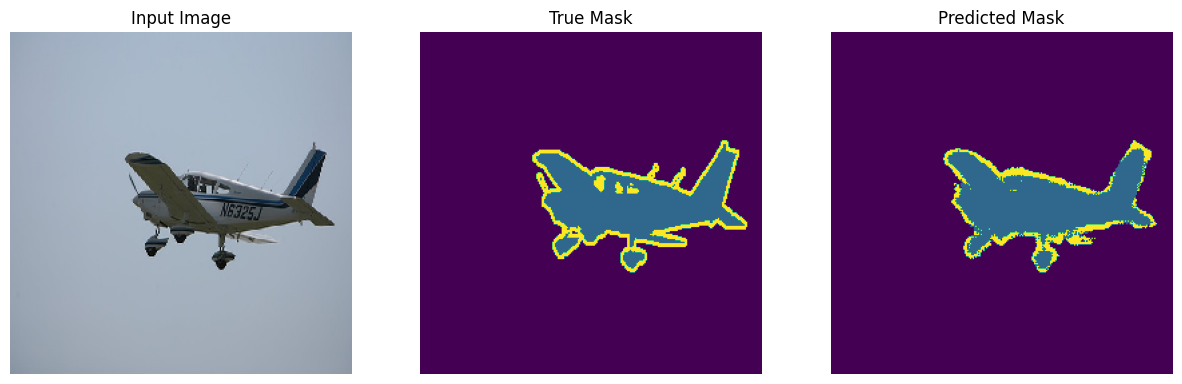

model_ue Class-wise IoU: [0.9063325, 0.8615674, 0.7281933, 0.3213966, 0.13286972, 0.8564508, 0.038929585, 0.7797702, 0.0, 0.0, 0.17799754, 0.88066316, 0.3573499, 0.15301535, 0.5318248, 0.2807426, 0.0, 0.69639355, 0.038263183, 0.7358896, 0.571219, 0.0]
model_ue Mean IoU score > 0.5:  0.7548304
model_ue Mean IoU score top 3:  0.8828543
model_ue Mean IoU score: 0.41131219267845154
1/1 [==============================] - 5s 5s/step


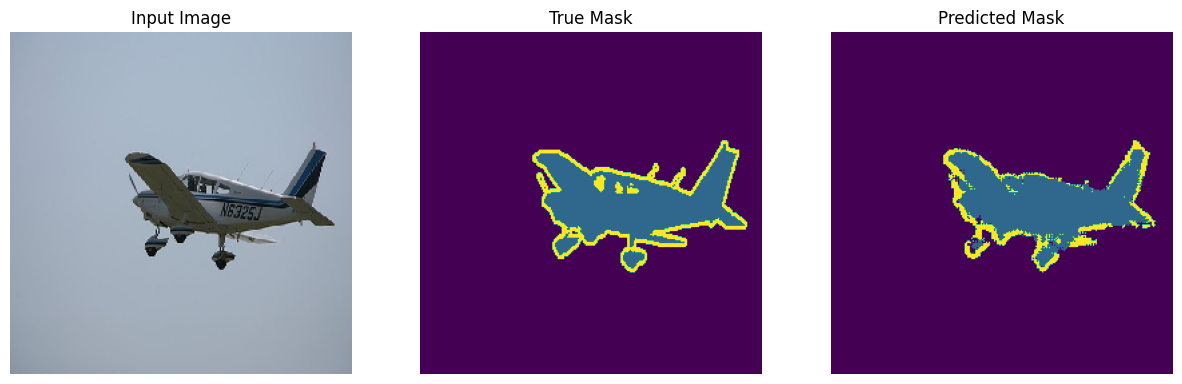

model_um Class-wise IoU: [0.90308076, 0.81153625, 0.6926715, 0.28983283, 0.49068978, 0.7492977, 0.022766078, 0.8242513, 0.0, 0.0, 0.73511773, 0.20319235, 0.48709202, 0.25090837, 0.28234187, 0.08814299, 0.31524846, 0.6038242, 0.44178617, 0.5015564, 0.7310999, 0.0]
model_um Mean IoU score > 0.5:  0.72804844
model_um Mean IoU score top 3:  0.8462894
model_um Mean IoU score: 0.428383469581604
1/1 [==============================] - 21s 21s/step


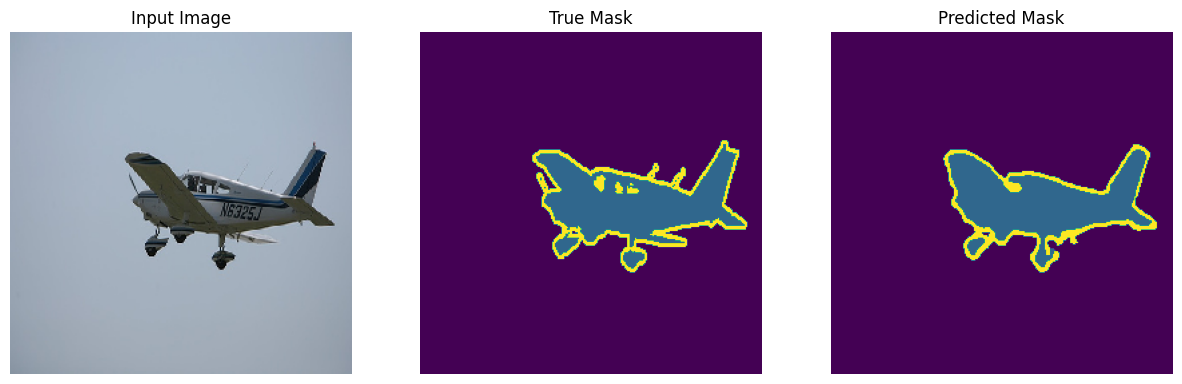

<ipython-input-74-baca11dc9bfb>:35: RuntimeWarning: invalid value encountered in float_scalars
  iou = true_positives / (true_positives + false_positives + false_negatives)


model_deeplab Class-wise IoU: [0.9268465, 0.8895023, 0.73773116, 0.34693915, 0.8363131, 0.71391755, 0.21609361, 0.96045685, nan, nan, 0.7401818, 0.730763, 0.19936809, 0.5337646, 0.3045994, 0.4828684, 0.92993534, 0.5751106, 0.2841012, 0.84771574, 0.78869635, nan]
model_deeplab Mean IoU score > 0.5:  0.78545654
model_deeplab Mean IoU score top 3:  0.9390796
model_deeplab Mean IoU score: 0.6339423656463623
------------------------------
1/1 [==============================] - 13s 13s/step


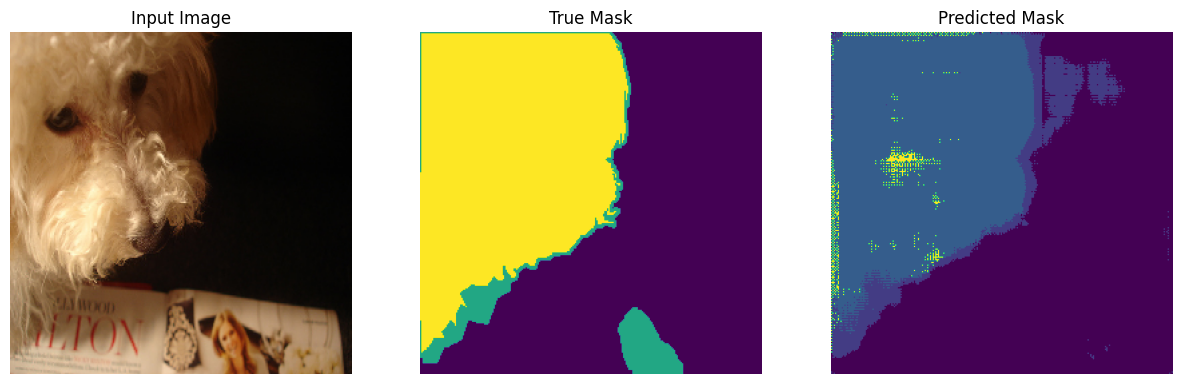

model_ue Class-wise IoU: [0.90990007, 0.39938602, 0.82362425, 0.35994413, 0.60246795, 0.64479816, 0.4432513, 0.017207552, 0.9302209, 0.38067684, 0.41214836, 0.8678769, 0.0, 0.13016193, 0.80831265, 0.5774988, 0.71965635, 0.6170968, 0.32297364, 0.86555177, 0.27306628, 0.7795323]
model_ue Mean IoU score > 0.5:  0.7622114
model_ue Mean IoU score top 3:  0.9026659
model_ue Mean IoU score: 0.5402433276176453
1/1 [==============================] - 6s 6s/step


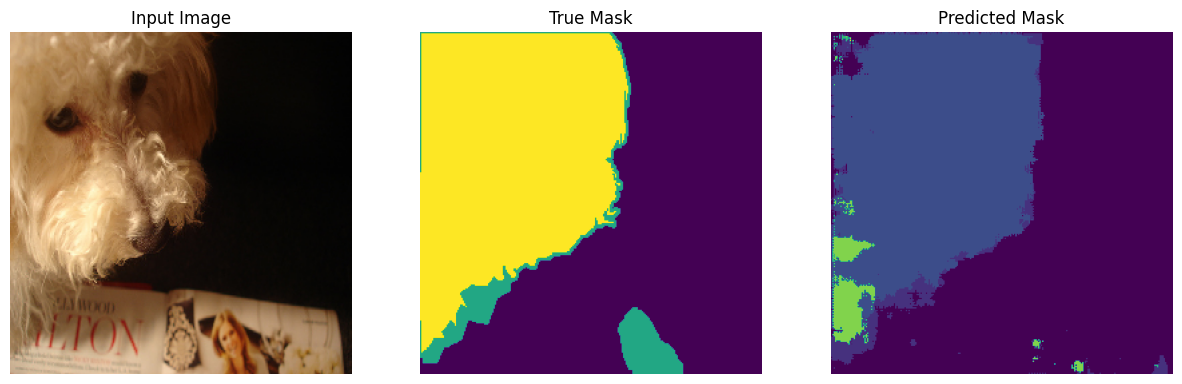

model_um Class-wise IoU: [0.9006054, 0.5149952, 0.78517, 0.29861912, 0.49714285, 0.66260695, 0.2788301, 0.8751292, 0.732509, 0.80882275, 0.77706605, 0.88151133, 0.0, 0.2683911, 0.58240646, 0.017907014, 0.7737611, 0.4079268, 0.8936632, 0.925067, 0.5825812, 0.767801]
model_um Mean IoU score > 0.5:  0.7642464
model_um Mean IoU score top 3:  0.9064452
model_um Mean IoU score: 0.601477861404419
1/1 [==============================] - 14s 14s/step


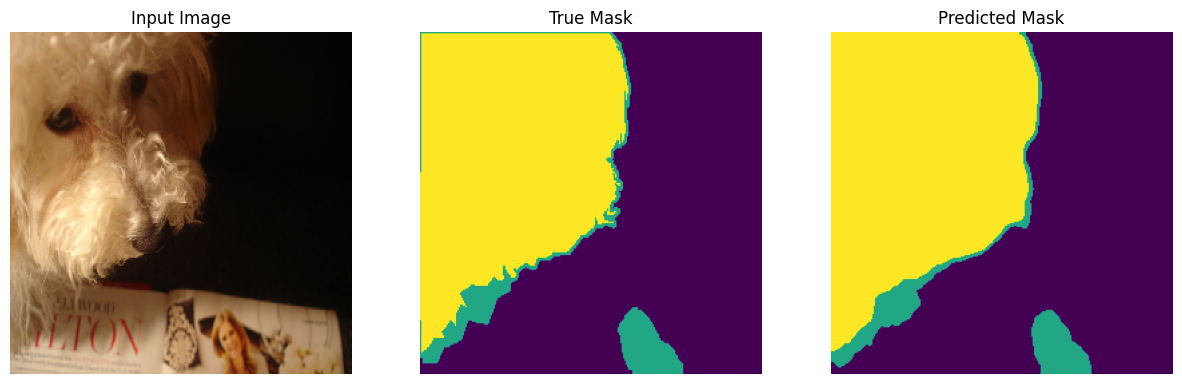

model_deeplab Class-wise IoU: [0.92041177, 0.6088409, 0.74219954, 0.36007416, 0.58353746, 0.9043157, 0.3897472, 0.93363166, 0.86344975, 0.58757746, 0.3726698, 0.8904548, 0.0, 0.5492867, 0.86838007, 0.78796244, 0.7681369, 0.77488124, 0.9010569, 0.77473295, 0.6813401, 0.78915805]
model_deeplab Mean IoU score > 0.5:  0.77385306
model_deeplab Mean IoU score top 3:  0.9194531
model_deeplab Mean IoU score: 0.6841747760772705
------------------------------
1/1 [==============================] - 16s 16s/step


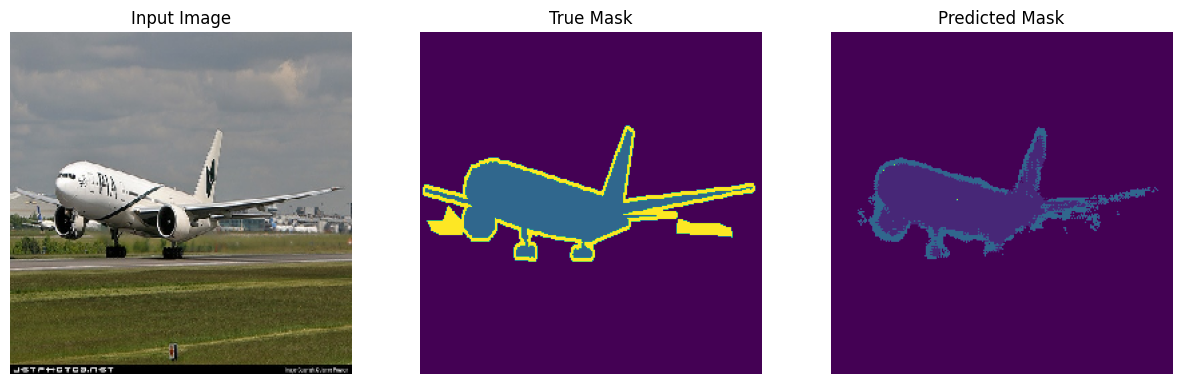

model_ue Class-wise IoU: [0.948037, 0.67365843, 0.7585018, 0.2900492, 0.8653183, 0.70033157, 0.7300979, 0.7752769, 0.0, 0.46674612, 0.33617887, 0.9082223, 0.0, 0.5075441, 0.77139586, 0.05672164, 0.6763532, 0.9484623, 0.81590885, 0.8632016, 0.55260485, 0.8574359]
model_ue Mean IoU score > 0.5:  0.77202195
model_ue Mean IoU score top 3:  0.9349072
model_ue Mean IoU score: 0.6137294173240662
1/1 [==============================] - 5s 5s/step


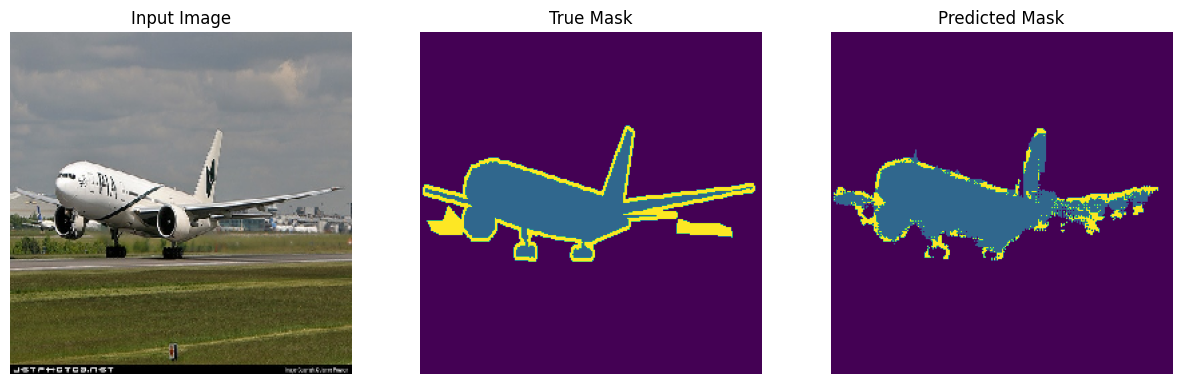

model_um Class-wise IoU: [0.9292729, 0.37160882, 0.7630881, 0.26838252, 0.9000264, 0.7364221, 0.4857719, 0.4680701, 0.12294043, 0.40110517, 0.287592, 0.84355444, 0.0, 0.60253614, 0.77793145, 0.024730502, 0.8301756, 0.9155082, 0.48837605, 0.8902842, 0.22335227, 0.49722627]
model_um Mean IoU score > 0.5:  0.81887996
model_um Mean IoU score top 3:  0.9149358
model_um Mean IoU score: 0.5376343131065369
1/1 [==============================] - 14s 14s/step


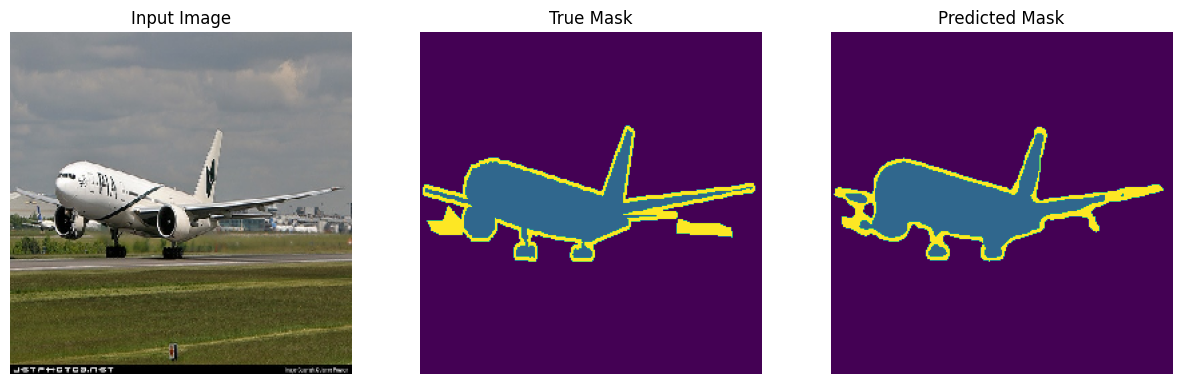

model_deeplab Class-wise IoU: [0.9146522, 0.83291066, 0.69693965, 0.26965323, 0.53291935, 0.47145608, 0.3932387, 0.7276884, 0.0, 0.5866303, 0.17271334, 0.93708676, 0.0, 0.81709164, 0.8416498, 0.16152143, 0.7548873, 0.90090644, 0.79043186, 0.9005277, 0.687391, 0.9180775]
model_deeplab Mean IoU score > 0.5:  0.78931934
model_deeplab Mean IoU score top 3:  0.9232722
model_deeplab Mean IoU score: 0.6049260497093201
------------------------------
1/1 [==============================] - 12s 12s/step


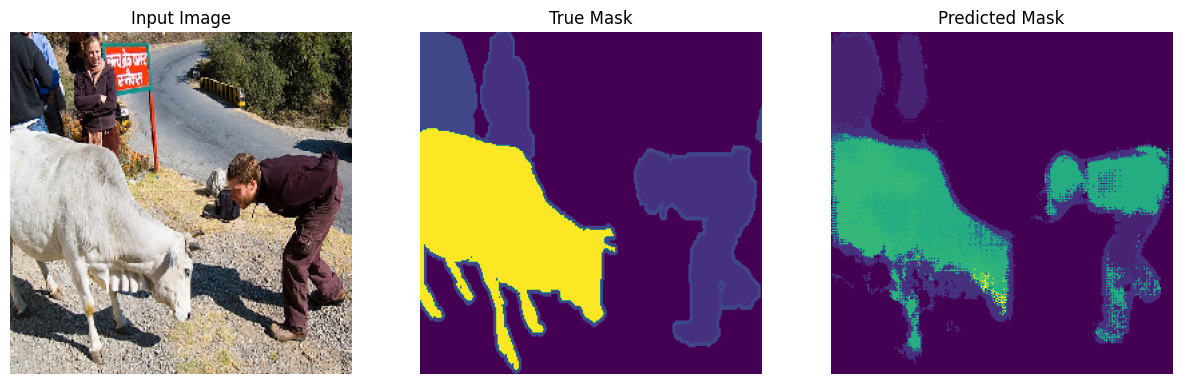

model_ue Class-wise IoU: [0.9208476, 0.0, 0.78180957, 0.31835154, 0.60094976, 0.618747, 0.38847652, 0.0, 0.041639313, 0.7315074, 0.024458421, 0.8674377, 0.6871019, 0.44815707, 0.74554515, 0.27787092, 0.1402128, 0.8791855, 0.7935263, 0.8396956, 0.0, 0.52965]
model_ue Mean IoU score > 0.5:  0.7496669
model_ue Mean IoU score top 3:  0.889157
model_ue Mean IoU score: 0.4834168255329132
1/1 [==============================] - 7s 7s/step


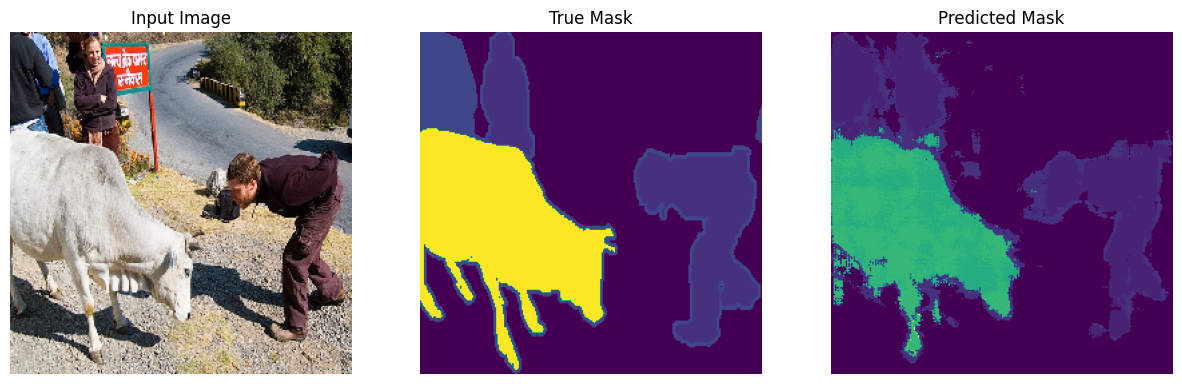

model_um Class-wise IoU: [0.8881785, 0.5312864, 0.65514505, 0.2690648, 0.47842014, 0.11327465, 0.15559708, 0.0, 0.04810379, 0.87882775, 0.22132927, 0.8224967, 0.54789555, 0.37875888, 0.70396566, 0.14524573, 0.8407543, 0.6590435, 0.25165516, 0.8670935, 0.0, 0.24763407]
model_um Mean IoU score > 0.5:  0.7394687
model_um Mean IoU score top 3:  0.8780332
model_um Mean IoU score: 0.4410804808139801
1/1 [==============================] - 14s 14s/step


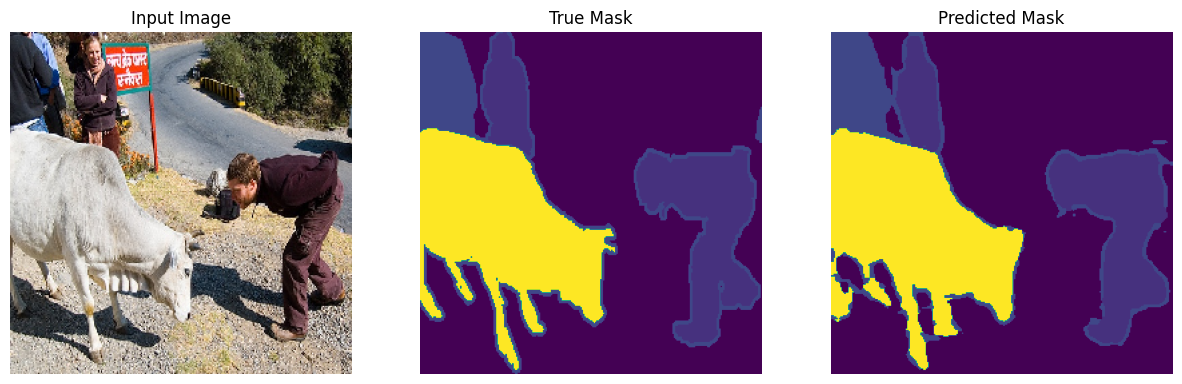

model_deeplab Class-wise IoU: [0.9178488, 0.4686425, 0.7829522, 0.32563466, 0.6114462, 0.034212068, 0.31722745, 0.0, 0.28161258, 0.5450754, 0.0, 0.9444134, 0.78152484, 0.90612155, 0.90518767, 0.56762, 0.30161235, 0.90868515, 0.518784, 0.8738172, 0.0, 0.38741866]
model_deeplab Mean IoU score > 0.5:  0.7719564
model_deeplab Mean IoU score top 3:  0.92364913
model_deeplab Mean IoU score: 0.5172653198242188
------------------------------
1/1 [==============================] - 13s 13s/step


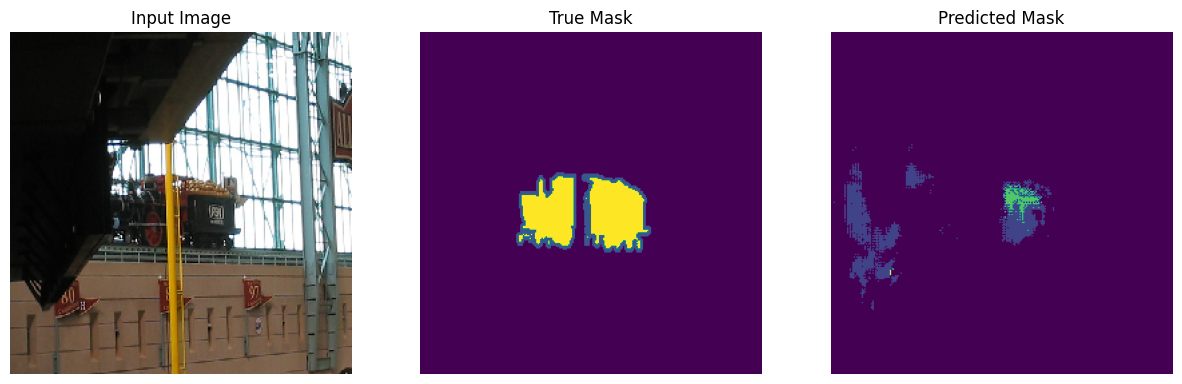

model_ue Class-wise IoU: [0.94214064, 0.6675151, 0.7939785, 0.3263725, 0.6295676, 0.91695774, 0.8936466, 0.0, 0.30031192, 0.6933986, 0.0015097294, 0.6483627, 0.0, 0.7855447, 0.80483645, 0.17363866, 0.0, 0.94445497, 0.0, 0.723331, 0.74394923, 0.68208367]
model_ue Mean IoU score > 0.5:  0.776412
model_ue Mean IoU score top 3:  0.9345178
model_ue Mean IoU score: 0.5305272936820984
1/1 [==============================] - 5s 5s/step


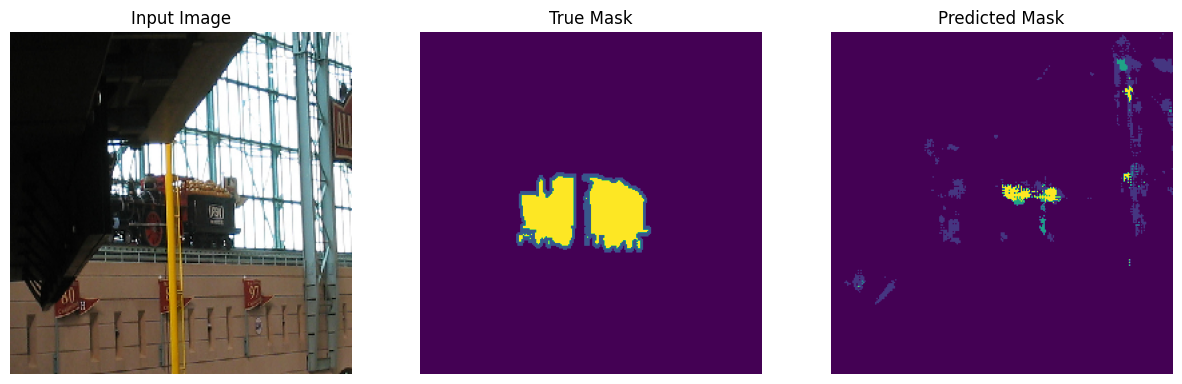

model_um Class-wise IoU: [0.9077238, 0.7569101, 0.7169736, 0.33502465, 0.8697761, 0.8187856, 0.45963055, 0.092920355, 0.087971315, 0.8746294, 0.56218153, 0.57861495, 0.0, 0.5282395, 0.52978617, 0.045359533, 0.0, 0.8395343, 0.0, 0.7436721, 0.5447422, 0.67709696]
model_um Mean IoU score > 0.5:  0.71061903
model_um Mean IoU score top 3:  0.88404304
model_um Mean IoU score: 0.4986169934272766
1/1 [==============================] - 14s 14s/step


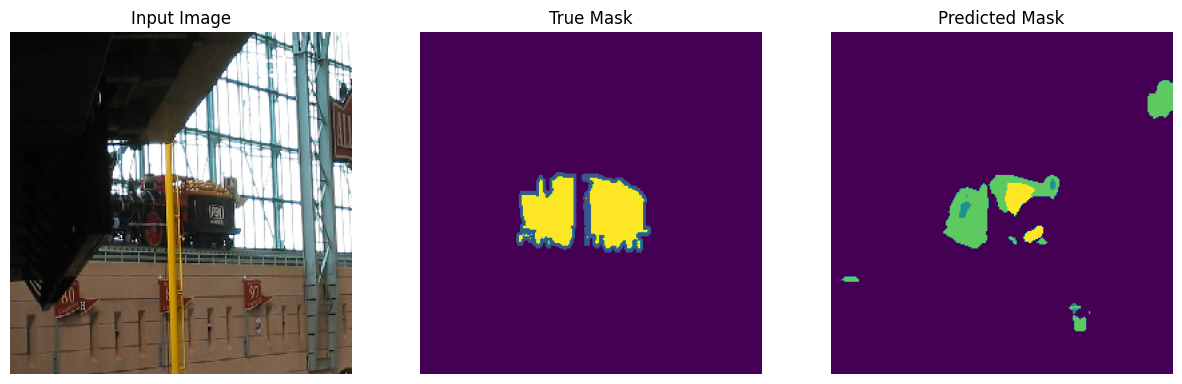

model_deeplab Class-wise IoU: [0.93722314, 0.82818526, 0.7950781, 0.45204973, 0.9515459, 0.8950613, 0.7879152, 0.0, 0.9609798, 0.86569375, 0.8354937, 0.40467775, 0.0, 0.5541597, 0.8452637, 0.2736945, 0.0, 0.8677432, 0.0, 0.76075715, 0.79605436, 0.7190119]
model_deeplab Mean IoU score > 0.5:  0.82667774
model_deeplab Mean IoU score top 3:  0.9499163
model_deeplab Mean IoU score: 0.6150267124176025
------------------------------
1/1 [==============================] - 13s 13s/step


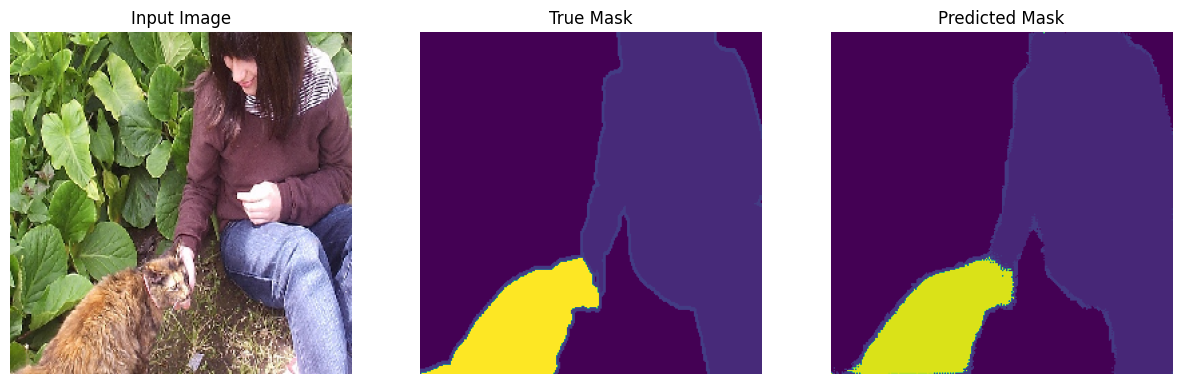

model_ue Class-wise IoU: [0.9276324, 0.21895729, 0.78105235, 0.22171877, 0.8750688, 0.6893543, 0.46694997, 0.8936068, 0.8378542, 0.34533235, 0.46916443, 0.6320235, 0.7075887, 0.0, 0.0, 0.5848447, 0.7883156, 0.8278722, 0.0, 0.8491993, 0.42022356, 0.20312022]
model_ue Mean IoU score > 0.5:  0.7828677
model_ue Mean IoU score top 3:  0.8987693
model_ue Mean IoU score: 0.5336308479309082
1/1 [==============================] - 6s 6s/step


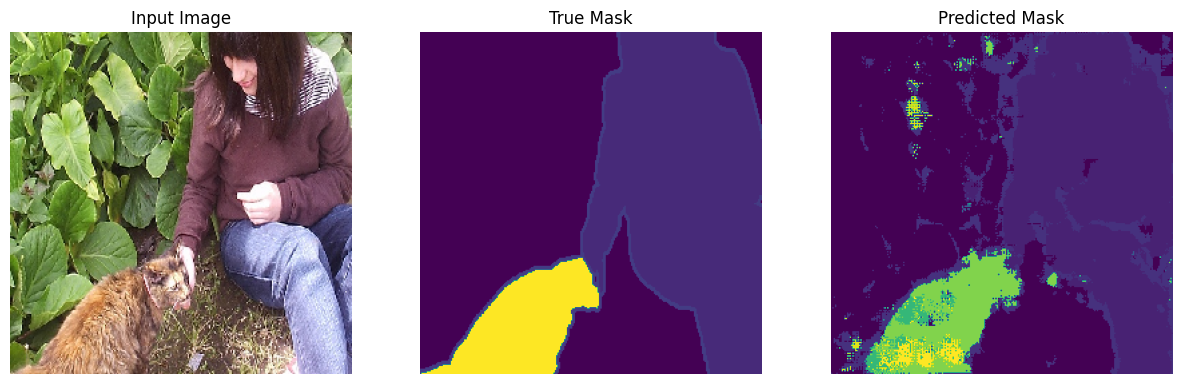

model_um Class-wise IoU: [0.9295966, 0.8059482, 0.8515583, 0.22817208, 0.8595225, 0.003475726, 0.38829336, 0.81616735, 0.7930053, 0.57834226, 0.25208387, 0.8882044, 0.81083256, 0.0, 0.0, 0.044400916, 0.70283085, 0.61573404, 0.0, 0.80675393, 0.0992268, 0.23664123]
model_um Mean IoU score > 0.5:  0.78820807
model_um Mean IoU score top 3:  0.8924412
model_um Mean IoU score: 0.48685407638549805
1/1 [==============================] - 14s 14s/step


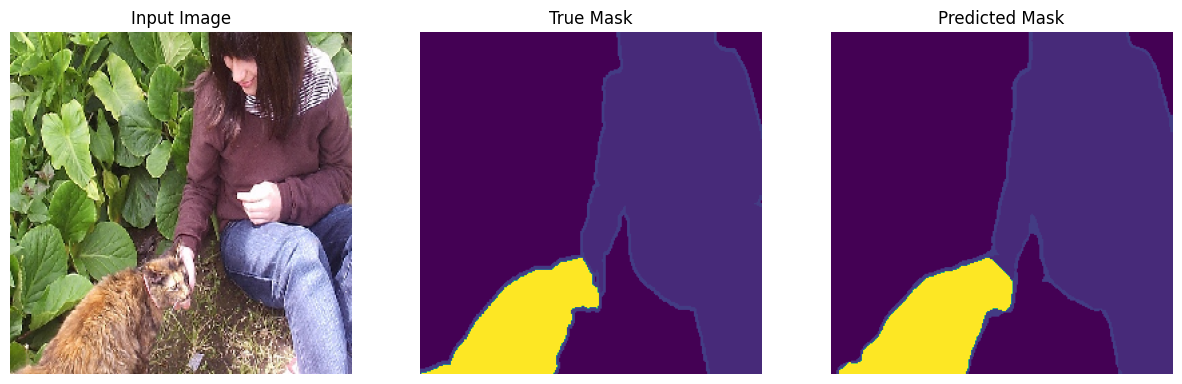

model_deeplab Class-wise IoU: [0.9256086, 0.8298262, 0.83950245, 0.2892646, 0.8616543, 0.9595625, 0.16256939, 0.76759267, 0.6903337, 0.70133555, 0.2863512, 0.0, 0.7356154, nan, 0.0, 0.41929078, 0.86732674, 0.7468303, 0.0, 0.5714811, 0.19077568, 0.7419893]
model_deeplab Mean IoU score > 0.5:  0.7875891
model_deeplab Mean IoU score top 3:  0.9174993
model_deeplab Mean IoU score: 0.5517576336860657
------------------------------
1/1 [==============================] - 13s 13s/step


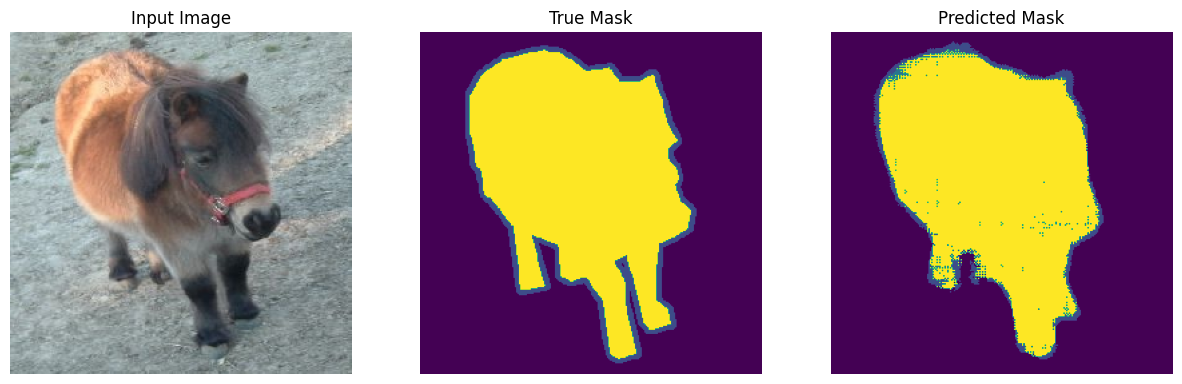

model_ue Class-wise IoU: [0.87767136, 0.7388993, 0.733634, 0.2509415, 0.55210257, 0.5744741, 0.62265855, 0.30599144, 0.0006476684, 0.69684356, 0.53917575, 0.402343, 0.0, 0.84919506, 0.83629894, 0.18105263, 0.9176148, 0.4811929, 0.00051981804, 0.48071894, 0.0, 0.86391187]
model_ue Mean IoU score > 0.5:  0.73354
model_ue Mean IoU score top 3:  0.8863993
model_ue Mean IoU score: 0.4957221746444702
1/1 [==============================] - 4s 4s/step


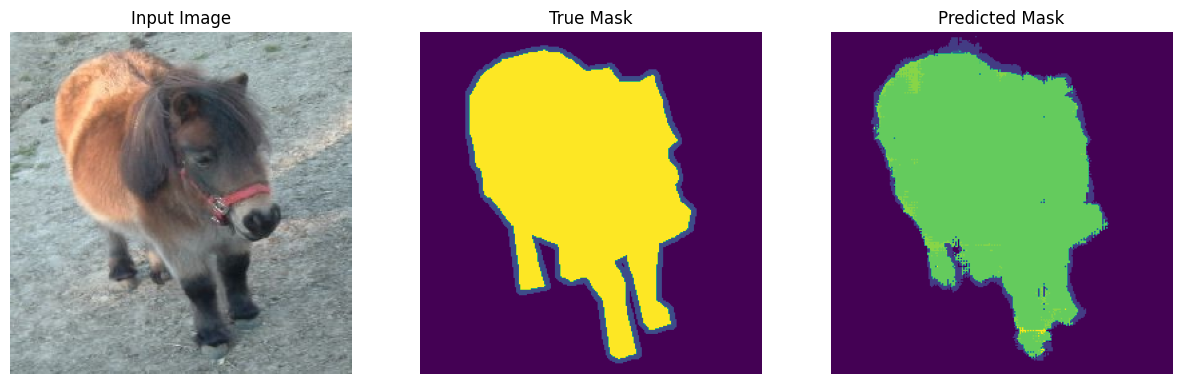

model_um Class-wise IoU: [0.8913931, 0.77121454, 0.7774874, 0.23508005, 0.5799872, 0.7765488, 0.37867016, 0.2633495, 0.012738854, 0.850504, 0.6545375, 0.9035467, 0.0, 0.77904356, 0.4785113, 0.06382979, 0.8867537, 0.7794713, 0.29372108, 0.8707025, 0.0, 0.4772212]
model_um Mean IoU score > 0.5:  0.79343253
model_um Mean IoU score top 3:  0.89389783
model_um Mean IoU score: 0.5329232811927795
1/1 [==============================] - 14s 14s/step


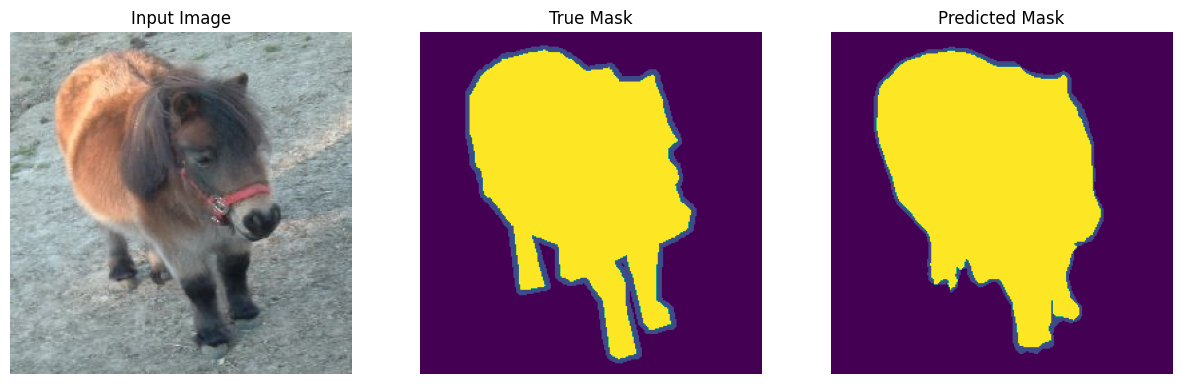

model_deeplab Class-wise IoU: [0.9246991, 0.9250821, 0.81248236, 0.29596034, 0.8829889, 0.7697094, 0.8373847, 0.7242614, 0.76538146, 0.9200397, 0.6235251, 0.7752884, 0.0, 0.89793146, 0.85754377, 0.3063291, 0.93617195, 0.8419925, 0.85890627, 0.8621421, nan, 0.925354]
model_deeplab Mean IoU score > 0.5:  0.84116024
model_deeplab Mean IoU score top 3:  0.9288693
model_deeplab Mean IoU score: 0.749674916267395
------------------------------
1/1 [==============================] - 16s 16s/step


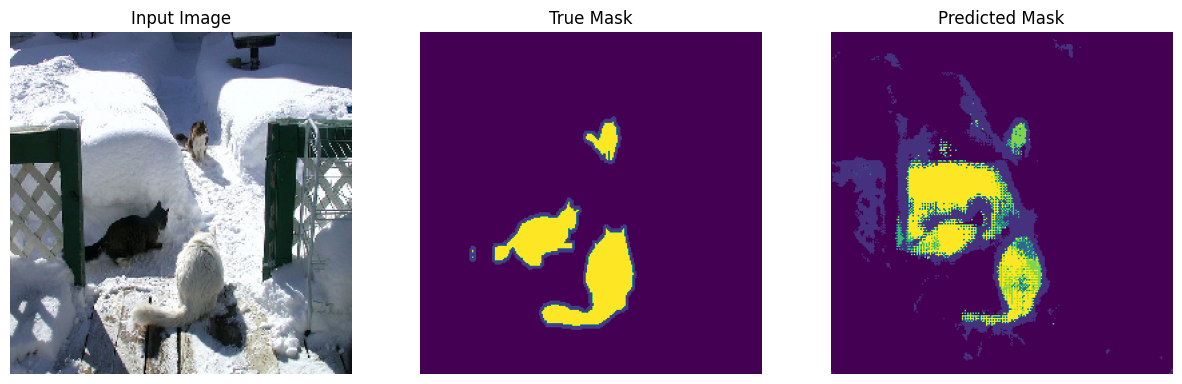

model_ue Class-wise IoU: [0.90548944, 0.06130268, 0.7376509, 0.27296153, 0.0, 0.00012201074, 0.12921825, 0.5520002, 0.18821023, 0.8466772, 0.18496564, 0.8148148, 0.43939245, 0.3789967, 0.17400105, 0.078682356, 0.15492958, 0.8592309, 0.33791143, 0.27912343, 0.0, 0.0]
model_ue Mean IoU score > 0.5:  0.7859772
model_ue Mean IoU score top 3:  0.8704658
model_ue Mean IoU score: 0.3361673057079315
1/1 [==============================] - 5s 5s/step


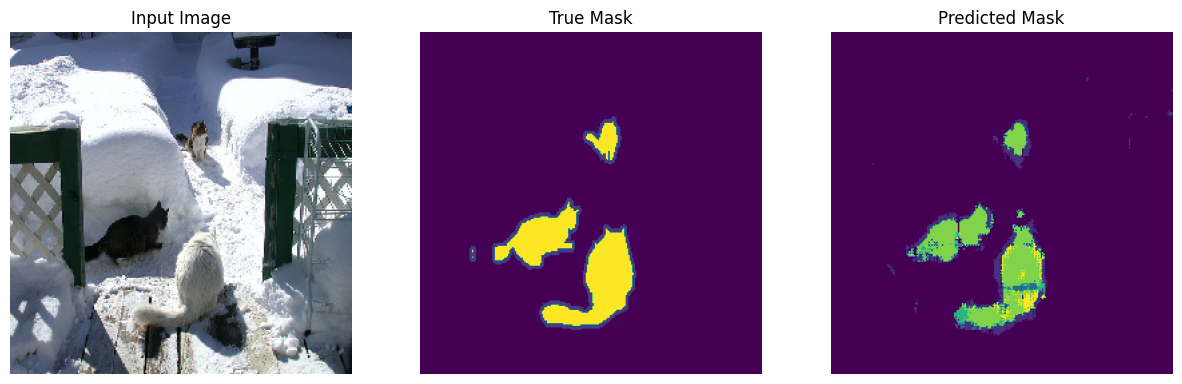

model_um Class-wise IoU: [0.90088713, 0.0, 0.6149435, 0.26727635, 0.0, 0.043063436, 0.02898295, 0.7323646, 0.012820513, 0.7708266, 0.099884056, 0.904146, 0.5267051, 0.648704, 0.7641429, 0.017146017, 0.0, 0.8547142, 0.34081843, 0.6787356, 0.010995052, 0.0]
model_um Mean IoU score > 0.5:  0.739617
model_um Mean IoU score top 3:  0.88658243
model_um Mean IoU score: 0.3735071122646332
1/1 [==============================] - 14s 14s/step


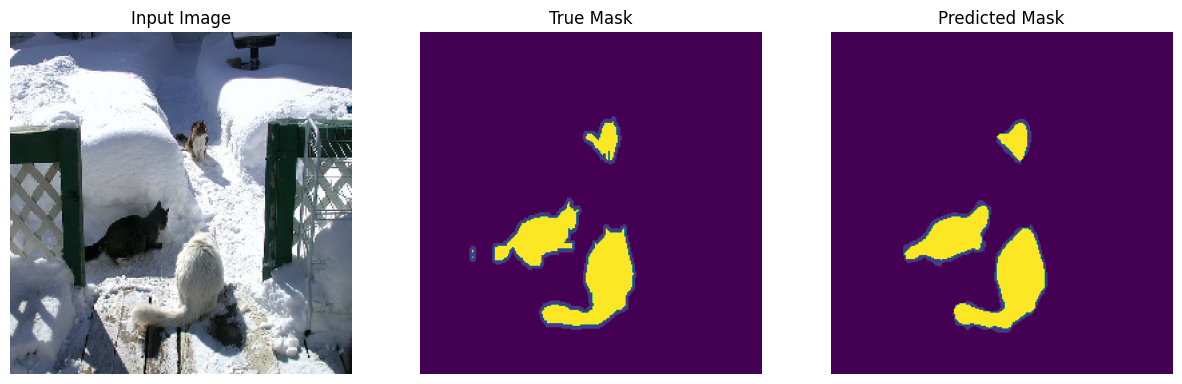

model_deeplab Class-wise IoU: [0.9262878, 0.005239521, 0.75163656, 0.3780123, 0.0, 0.0, 0.3842321, 0.7760937, 0.53846157, 0.7386602, 0.67950624, 0.89280117, 0.5575413, 0.72486514, 0.7345669, 0.22410686, 0.035399757, 0.9593335, 0.4763613, 0.0, 0.0, 0.0]
model_deeplab Mean IoU score > 0.5:  0.75270486
model_deeplab Mean IoU score top 3:  0.9261408
model_deeplab Mean IoU score: 0.444686621427536
------------------------------
1/1 [==============================] - 12s 12s/step


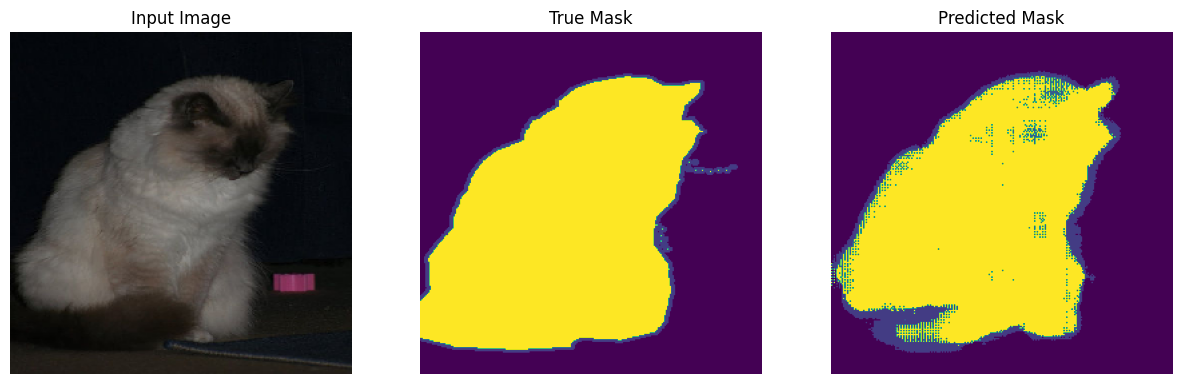

model_ue Class-wise IoU: [0.91802, 0.3015239, 0.71141845, 0.28111744, 0.6100082, 0.75967294, 0.40310612, 0.05671642, 0.93693274, 0.44440028, 0.9528598, 0.9333467, 0.8844498, 0.72188216, 0.32801446, 0.0, 0.84073967, 0.8877752, 0.0, 0.9100729, 0.521576, 0.48837623]
model_ue Mean IoU score > 0.5:  0.81451964
model_ue Mean IoU score top 3:  0.9410464
model_ue Mean IoU score: 0.5860004425048828
1/1 [==============================] - 5s 5s/step


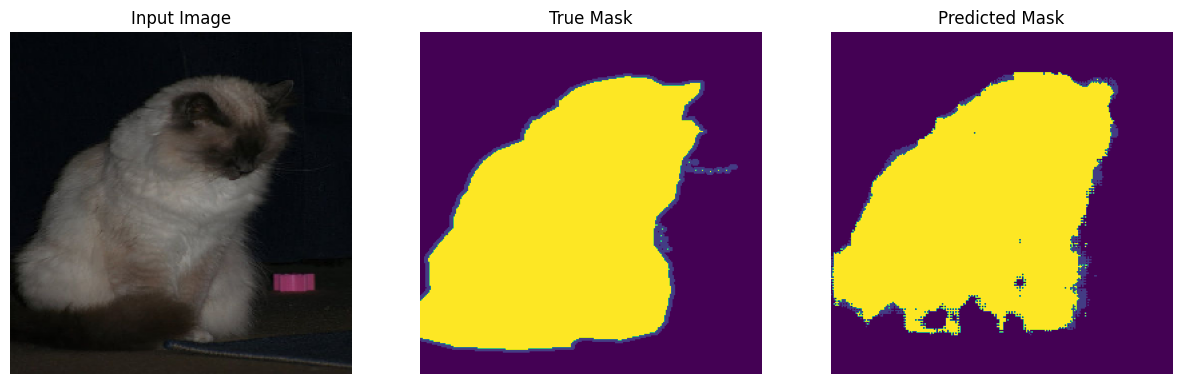

model_um Class-wise IoU: [0.85281193, 0.66649693, 0.5905821, 0.2882801, 0.53674203, 0.90432763, 0.07816997, 0.038554218, 0.19494262, 0.7792189, 0.12464693, 0.29969493, 0.9222702, 0.64856595, 0.45489433, 0.0, 0.83343506, 0.6499388, 0.0, 0.9579711, 0.182887, 0.82681185]
model_um Mean IoU score > 0.5:  0.76409763
model_um Mean IoU score top 3:  0.9281896
model_um Mean IoU score: 0.4923292100429535
1/1 [==============================] - 15s 15s/step


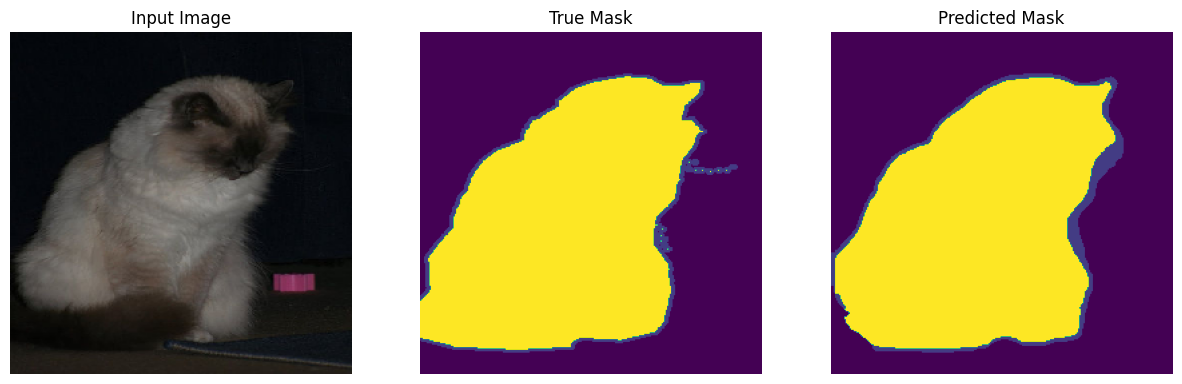

model_deeplab Class-wise IoU: [0.90487266, 0.71446365, 0.57870364, 0.30613327, 0.5695496, 0.8805028, 0.6385705, 0.014126633, 0.7211563, 0.463404, 0.42062902, 0.37990823, 0.9382447, 0.86227876, 0.6689936, 0.0, 0.9202328, 0.6647051, 0.0, 0.86556536, 0.21489222, 0.91094714]
model_deeplab Mean IoU score > 0.5:  0.77419907
model_deeplab Mean IoU score top 3:  0.9231415
model_deeplab Mean IoU score: 0.5744491219520569
------------------------------
1/1 [==============================] - 1s 1s/step


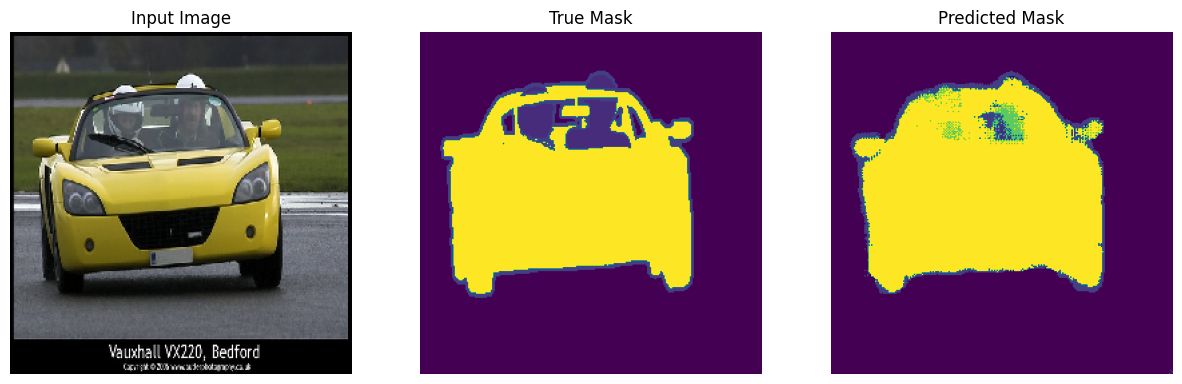

model_ue Class-wise IoU: [0.9646788, nan, 0.58731633, 0.25921097, nan, nan, nan, nan, 0.0, nan, nan, 0.90209246, 0.79934317, nan, nan, nan, 0.8455843, nan, nan, 0.0, nan, nan]
model_ue Mean IoU score > 0.5:  0.81980306
model_ue Mean IoU score top 3:  0.90411854
model_ue Mean IoU score: 0.5447782874107361
1/1 [==============================] - 1s 501ms/step


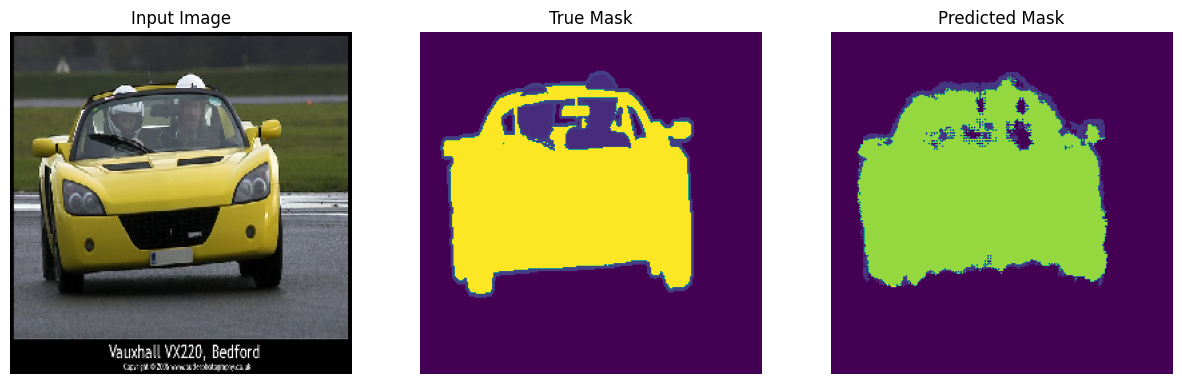

model_um Class-wise IoU: [0.94132346, nan, 0.3427686, 0.22263558, nan, 0.0, nan, nan, nan, nan, nan, 0.8573213, 0.6685525, nan, nan, 0.0, 0.8265857, nan, nan, 0.0, nan, nan]
model_um Mean IoU score > 0.5:  0.8234458
model_um Mean IoU score top 3:  0.87507683
model_um Mean IoU score: 0.4287985563278198
1/1 [==============================] - 2s 2s/step


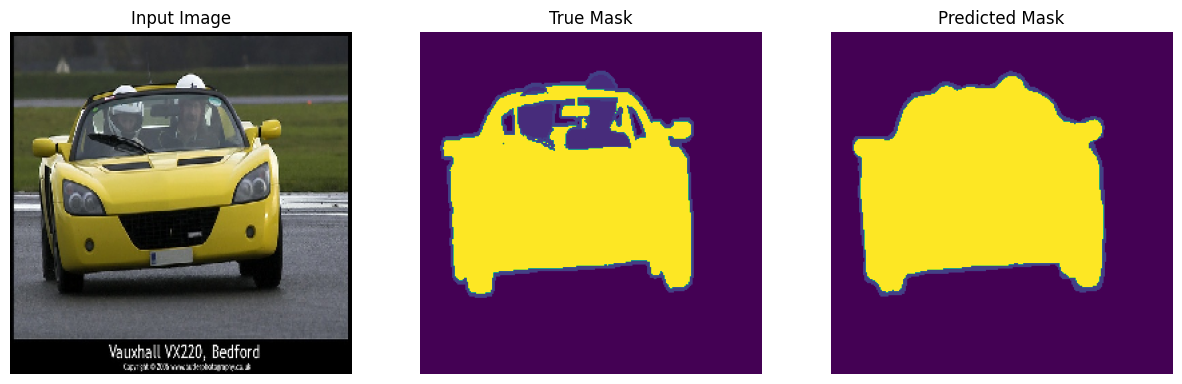

model_deeplab Class-wise IoU: [0.9492663, nan, 0.39482734, 0.25550064, nan, nan, nan, nan, nan, nan, nan, 0.8519187, 0.686643, nan, nan, nan, 0.84761196, nan, nan, nan, nan, nan]
model_deeplab Mean IoU score > 0.5:  0.83386
model_deeplab Mean IoU score top 3:  0.88293236
model_deeplab Mean IoU score: 0.6642946600914001
------------------------------


In [75]:
model_list = {"model_ue":model_ue, "model_um":model_um, "model_deeplab":model_deeplab}
calculate_miou_custom(model_list, num_classes)

---


In [37]:
def calculate_iou(y_true, y_pred, smooth=1e-6):
    y_pred = np.squeeze(y_pred,-1)
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / (np.sum(union) + smooth)
    return iou